# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Требуется построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

Загрузим необходимые библиотеки.

In [1]:
import os
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузим csv-файл из папки с данными изображений и изучим его.

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
display(data.describe(include= 'all'))

,file_name,real_age
count,7591,7591.000000
unique,7591,NaN
top,003513.jpg,NaN
freq,1,NaN
mean,NaN,31.201159
std,NaN,17.145060
min,NaN,1.000000
25%,NaN,20.000000
50%,NaN,29.000000
75%,NaN,41.000000


Мы имеем набор данных, в котором 7591 изображение с лицами людей с возрастом от 1 до 100 лет. Поэтому для точного обучения модели и определении качества предсказаний возраста человека этого набора недостачно. Набор можно расширить создав копии изображений, преобразуя их с помощью поворота, смещения, отражения. Для этого применим аугментацию когда будем разделять данные на тренировочную и тестовую выборки.

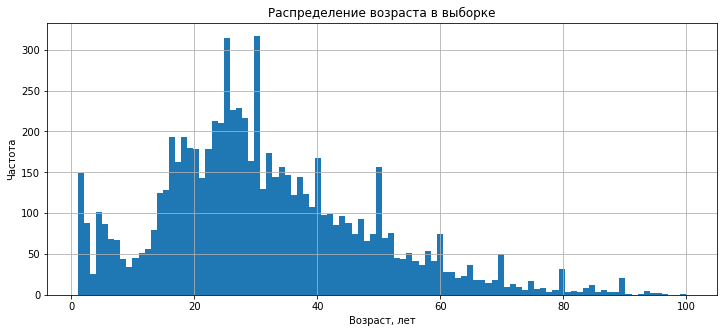

In [6]:
data.hist(bins=100, figsize=(12, 5))
plt.xlabel('Возраст, лет')
plt.ylabel('Частота')
plt.title('Распределение возраста в выборке')
plt.show()

Выведем на экран несколько изображений.

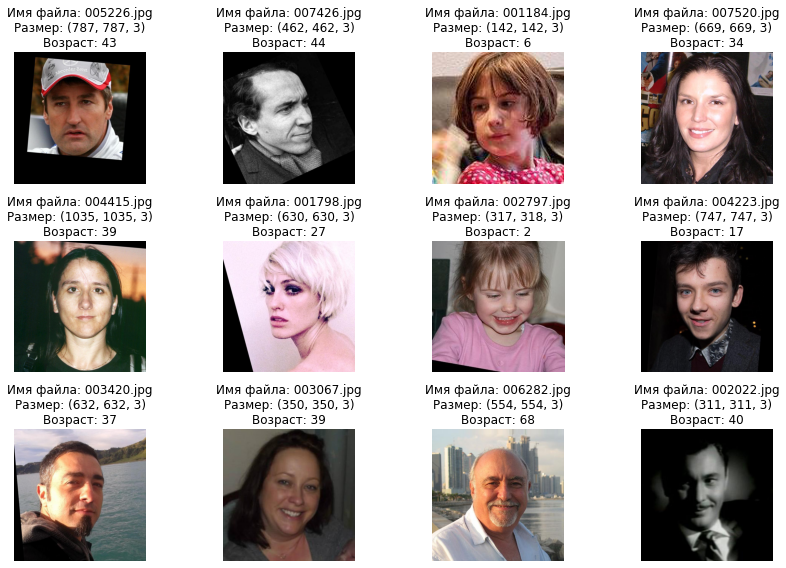

In [7]:
folder_path = '/datasets/faces/final_files/' 
image_names = os.listdir(folder_path)

# Создание словаря, связывающего имя файла с возрастом
age_dict = pd.Series(data.real_age.values, index=data.file_name).to_dict()

num_images_to_display = 12

fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    if i < num_images_to_display:
        image_path = os.path.join(folder_path, image_names[i])
        img = Image.open(image_path)
        
        # Print the shape of the image
        img_shape = np.asarray(img).shape
        
        # Get the filename
        filename = os.path.basename(image_path)
        
        # Get the age from the dictionary
        age = age_dict[filename]
        
        ax.set_title(f"Имя файла: {filename}\nРазмер: {img_shape}\nВозраст: {age}")
        
        # Display the image
        ax.imshow(img)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

Изучив фотографии можно выделить следующие особенности набора изображений:
- в наборе содержатся изображения с лицами людей,
- изображения имеют разный размер,
- возраст людей соответствует изображению,
- лица занимают большую часть фотографии,
- изображения имеют разную яркость и контрастность,
- выражения лиц разные,
- разные поворот и наклон головы,
- фотографии сделаны в условиях с разной степенью освещенности,
- направление взгляда разное.

Учитывая эти особенности и достаточно небольшой по размеру набор изображений, для улучшения обучения модели и повышения качества предсказаний необходимо расширить набор изображений применив аугментацию с помощью ImageDataGenerator на этапе разделения данных на тренировочную и тестовую выборки.

**Выводы**

Загрузили и изучили предоставленные данные. 

Получили набор данных, состоящий из 7591 изображения лица человека и записи о возрасте этого человека.

По возрасту объекты делятся неравномерно, средний возраст - 31.2 года, стандартное отклонение - 17.14, минимальны возраст - 1 год, максимальный - 100 лет.

Наименьшее количество изображений соответствуют старшему возрасту, поэтому модель здесь будет чаще ошибаться.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import os
import pandas as pd

from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
  
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv') 
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        subset='training',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)
 
    return train_datagen_flow
    
def load_test(path):  
    labels = pd.read_csv(path + 'labels.csv') 
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        subset='validation',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)
 
    return test_datagen_flow
    
def create_model(input_shape):
    optimizer = Adam(lr=0.0002)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)                
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
 
    return model    

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs, 
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/5
2023-11-17 10:02:16.785895: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-11-17 10:02:17.173440: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 131s - loss: 195.6865 - mae: 10.4226 - val_loss: 308.8981 - val_mae: 13.0261
Epoch 2/5
356/356 - 120s - loss: 109.2026 - mae: 7.9311 - val_loss: 147.1107 - val_mae: 9.1444
Epoch 3/5
356/356 - 123s - loss: 93.0972 - mae: 7.3135 - val_loss: 95.1596 - val_mae: 7.4202
Epoch 4/5
356/356 - 123s - loss: 80.2847 - mae: 6.8118 - val_loss: 90.0003 - val_mae: 7.0960
Epoch 5/5
356/356 - 122s - loss: 64.2682 - mae: 6.1269 - val_loss: 91.4083 - val_mae: 7.2259

119/119 - 30s - loss: 93.5129 - mae: 7.3190
Test MAE: 7.3190

```

## Анализ обученной модели

**Выводы**

Для улучшения качества модели с помощью ImageDataGenerator применили аугментацию - горизонтальное отражение, сдвиг и увеличение (зум) изображения. Разделили фрейм на тренировочный и тестовый. Так как все изображения у нас разного размера, привели их к одному размеру- 224х224, а количество изображений в батче установили 16.

Для обучения использовали модель ResNet50 из библиотеки Keras с весами, предобученными на датасете ImageNet. Для подбора шага обучения применили алгоритм Adam с подобранным гиперпараметром lr=0.0002.

Обучили модель на пяти эпохах.

По результатам тестирования модели получили MAE равное 7.3190, что меньше минимально допустимой MAE = 8.

Поставленная задача выполнена.